### Code written on Windows Machine

# [COM6513] Assignment 2: Text Classification with a Feedforward Network


### Instructor: Nikos Aletras


The goal of this assignment is to develop a Feedforward neural network for text classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  (**2 marks**)


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** (**2 marks**)
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** (**2 marks**)
    - **Output layer** with a **softmax** activation. (**2 marks**)


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function (**2 marks**)
    - Perform a **Forward pass** to compute intermediate outputs (**5 marks**)
    - Perform a **Backward pass** to compute gradients and update all sets of weights (**12 marks**)
    - Implement and use **Dropout** after each hidden layer for regularisation (**4 marks**)



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500}, the dropout rate {e.g. 0.2, 0.5} and the learning rate. Please use tables or graphs to show training and validation performance for each hyperparameter combination  (**5 marks**). 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? (**2 marks**).



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? (**7 marks**).



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations (**8 marks**)


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices (**5 marks**). 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in [Intro to Python for NLP](https://sheffieldnlp.github.io/com6513/assets/labs/a0_python_intro.pdf) (**2 marks**). 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You should submit a Jupyter Notebook file (assignment2.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

This assignment will be marked out of 60. It is worth 60\% of your final grade in the module.

The deadline for this assignment is **23:59 on Fri, 23 Apr 2021** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train = pd.read_csv("data_topic/train.csv",names= ['Topic','Articles'])
dev = pd.read_csv("data_topic/dev.csv",names= ['Topic','Articles'])
test = pd.read_csv("data_topic/test.csv",names= ['Topic','Articles'])

In [3]:

train_articles = train['Articles'].values.tolist()

dev_articles = dev['Articles'].values.tolist()

test_articles = test['Articles'].values.tolist()


In [4]:
test.head()

,Topic,Articles
0,1,Canadian Press - VANCOUVER (CP) - The sister o...
1,1,AP - The man who claims Gov. James E. McGreeve...
2,1,"NAJAF, Iraq - Explosions and gunfire rattled t..."
3,1,"LOURDES, France - A frail Pope John Paul II, b..."
4,1,Supporters and rivals warn of possible fraud; ...


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [5]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']


### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [6]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    
    tokenRE = re.compile(token_pattern)
    
    # first extract all unigrams by tokenising
    x_uni = [w for w in tokenRE.findall(str(x_raw).lower(),) if w not in stop_words]
    
    
    # this is to store the ngrams to be returned
    x = []
    

    
    if ngram_range[0]==1:
        x = x_uni


    # generate n-grams from the available unigrams x_uni
    ngrams = []
    for n in range(ngram_range[0], ngram_range[1]+1):

    # ignore unigrams
        if n==1: continue

        # pass a list of lists as an argument for zip
        arg_list = [x_uni]+[x_uni[i:] for i in range(1, n)]

        # extract tuples of n-grams using zip
        # for bigram this should look: list(zip(x_uni, x_uni[1:]))
        # align each item x[i] in x_uni with the next one x[i+1]. 
        # Note that x_uni and x_uni[1:] have different lenghts
        # but zip ignores redundant elements at the end of the second list
        # Alternatively, this could be done with for loops
        x_ngram = list(zip(*arg_list))
        ngrams.append(x_ngram)


    for n in ngrams:
        for t in n:
            x.append(t)

    if len(vocab)>0:
        x = [w for w in x if w in vocab]
        
    return x







### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [7]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
              min_df=0, keep_topN=0, 
              stop_words=[]):
    
    
    tokenRE = re.compile(token_pattern)
    
    df = Counter()
    ngram_counts = Counter()
    vocab = set()
    
    # interate through each raw text
    for x in X_raw:
        
        x_ngram = extract_ngrams(x, ngram_range=ngram_range, token_pattern=token_pattern, 
                                 stop_words=stop_words)
        
        #update doc and ngram frequencies 
        df.update(list(set(x_ngram)))
        ngram_counts.update(x_ngram)

    # obtain a vocabulary as a set. 
    # Keep elements with doc frequency > minimum doc freq (min_df)
    # Note that df contains all te
    vocab = set([w for w in df if df[w]>=min_df])
    
    # keep the top N most freqent 
    if keep_topN>0:
        vocab = set([w[0] for w in ngram_counts.most_common(keep_topN) 
                     if w[0] in vocab])
    
    
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [8]:
vocab, df, ngram_counts = get_vocab(train_articles, 
                          ngram_range=(1,1), 
                          stop_words=stop_words,
                          min_df=3, keep_topN=2000)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [9]:
vocabid_word_dict = dict(zip(range(len(vocab)),vocab))
word_vocabid_dict = dict(zip(vocab,range(len(vocab))))

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [10]:
train_ngrams=[]
dev_ngrams=[]
test_ngrams=[]

#Step 1: extract all the ngrams from each row in the dataset
#Step 2: find the words which are present in the vocab
#Step 3: add the common words to the list


for articles in train_articles:
    ngrams = extract_ngrams(articles,                             
                            ngram_range=(1,1), 
                            stop_words=stop_words)
    train_ngrams.append(list(set(ngrams).intersection(vocab)))

for articles in dev_articles:
    ngrams = extract_ngrams(articles,                             
                            ngram_range=(1,1), 
                            stop_words=stop_words)
    dev_ngrams.append(list(set(ngrams).intersection(vocab)))

for articles in test_articles:
    ngrams = extract_ngrams(articles,                             
                            ngram_range=(1,1), 
                            stop_words=stop_words)
    test_ngrams.append(list(set(ngrams).intersection(vocab)))
    

Then convert them into lists of indices in the vocabulary:

In [11]:
X_tr = [[list(vocab).index(gram) for gram in ngrams if gram in vocab ] for ngrams in train_ngrams]
X_dev = [[list(vocab).index(gram) for gram in ngrams if gram in vocab ] for ngrams in dev_ngrams]
X_te = [[list(vocab).index(gram) for gram in ngrams if gram in vocab ] for ngrams in test_ngrams]


Put the labels `Y` for train, dev and test sets into arrays: 

In [12]:
train_values = train['Topic'].to_numpy()
dev_values = dev['Topic'].to_numpy()
test_values = test['Topic'].to_numpy()


#converting labels using one hot encoding
Y_tr = np.zeros((len(train_values), 3)) 
for i in range(len(train_values)): 
    Y_tr[i, train_values[i]-1] = 1
    
Y_dev = np.zeros((len(dev_values), 3)) 
for i in range(len(dev_values)): 
    Y_dev[i, dev_values[i]-1] = 1
    
test_labels = np.zeros((len(test_values), 3)) 
for i in range(len(test_values)): 
    test_labels[i, test_values[i]-1] = 1

In [13]:
#changing the range of labels from 1,2,3 to 0,1,3 to match with the predicted labels
Y_te = [x-1 for x in test_values]

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [14]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.5):
    
    W={}
    
    # when there is no hidden layer
    if not hidden_dim:
        hidden_dim.append(0)
        
    for i in range(hidden_dim[0]+2):
        if i == 0:
            W.update({i:np.float32(np.random.uniform(-0.1, 0.1, (vocab_size,embedding_dim))*(1/init_val))})
        else:
            W.update({i:np.float32(np.random.uniform(-0.1, 0.1, (embedding_dim,embedding_dim))*(1/init_val))})
    
    N = len(W)
    #weights for output layer calculation
    W[N-1] = np.float32(np.random.uniform(-0.1, 0.1, (embedding_dim,num_classes))*(1/init_val))
    
    
    #W = {0:np.random.uniform(-0.1, 0.1, (vocab_size,embedding_dim))*init_val,
    #     1:np.random.uniform(-0.1, 0.1, (embedding_dim,embedding_dim))*init_val,
    #     2:np.random.uniform(-0.1, 0.1, (embedding_dim,num_classes))*init_val}

    return W
    

In [15]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [16]:
def softmax(z):
    exp_scores = np.exp(z)
    softmax = exp_scores / np.sum(exp_scores, keepdims=True)
    return softmax



Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [17]:
def categorical_loss(y, y_preds):
    
    #l = -np.sum((y*np.log2(y_preds)+(1-y)*np.log2(1-y_preds)))
    epsilon =1e-12  #small value to avoid instability
    y_preds = np.clip(y_preds,epsilon,1.-epsilon)
    y_preds_shape = y_preds.shape[0]
    l = -np.sum(y*np.log(y_preds+1e-9))/y_preds_shape    
    
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [18]:
def relu(z):
    
    a = np.where(z>0,z,0)
    
    return a
    
def relu_derivative(z):
    
    dz = np.where(z<=0,0,1)
    
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [19]:
def dropout_mask(size, dropout_rate):
    
    
    n_zeros = size*dropout_rate
    dropout_vec = list(map(float,(np.array([1] * (size-int(n_zeros)) + [0] * (int(n_zeros))))))
    random.shuffle(dropout_vec)
    
    
    return dropout_vec
    
    

In [20]:
print(dropout_mask(10, 0.3))


[0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [21]:
def forward_pass(x, W, dropout_rate=0.2):
    
    
    out_vals = {}
    
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    
    #Looking up the weight matrix for indices in the vocabulary
    n = W[0].shape[1]
    h_vecs.append((np.sum(W[0][x,:],axis=0)*1/len(x)).reshape(1,n))     
    
    #computing output_vals
    for i in range(1,len(W)-1):
        h_vecs.append(h_vecs[i-1].dot(W[i]))
        a_vecs.append(relu(h_vecs[i]))
        dropout_vecs.append(dropout_mask(len(a_vecs[i-1]), dropout_rate)*a_vecs[i-1])
        #a_vecs[i-1] = dropout_vecs[i-1]*a_vecs[i-1]
        
    
    #h_vecs.append(np.dot(h_vecs[0] , W[1]))
    #a_vecs.append(relu(h_vecs[1]))
    #dropout_vecs.append((dropout_mask(len(a_vecs[0]), dropout_rate))*a_vecs[0])
    
    #output layer
    h_vecs.append(h_vecs[-1].dot(W[len(W)-1]))
    a_vecs.append(softmax(h_vecs[-1]))
    dropout_vecs.append(a_vecs[-1])
    
    out_vals = {"H": h_vecs,
                "A": a_vecs ,
                "D": dropout_vecs,
                "y": softmax(h_vecs[-1][0])}
    
    return out_vals
    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [22]:
def backward_pass(x, y, W, out_vals, lr=0.01, freeze_emb=False):

    for i in range(len(W),0,-1):         
        if i == len(W):            
            prev_error = out_vals['y'] - y  #actual error            
        else:
                error  = prev_error * relu_derivative(out_vals['D'][i-1])
                grad = out_vals['H'][i-1].T.dot(error)
                prev_error = error.dot(W[i].T)
                W[i] -=  lr*grad
    
    #updating weights for emebedding matrix
    if freeze_emb == True:
        error = prev_error * relu_derivative(out_vals['H'][0])
        grad  = W[0][x,:].T.dot(error)
        W[0]  -= lr*grad
        
    
    
    #output_error = out_vals['Output'] - y
    
    #output_grad = output_error * relu_derivative(out_vals['D'][1])
    ##output_grad = output_error * relu_derivative(out_vals['A'][1])
    
    #a1_error = np.dot(output_grad,W[2].T)
    #a1_grad = a1_error * relu_derivative(out_vals['D'][0])
    ##a1_grad = a1_error * relu_derivative(out_vals['A'][0])
    
    #W[1] -= np.dot(out_vals['H'][0].T,a1_grad) *lr
    #W[2] -= np.dot(out_vals['H'][1].T,output_grad)*lr
    
    
    return W




Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [23]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, 
        print_progress=True):
    
    
    training_loss_history = []
    validation_loss_history = []
    num_instances_tr = len(X_tr)
    num_instances_dev = len(X_dev)
    
    print("Training started:")
    for e in range(epochs):
        
        indices_tr = np.random.permutation(num_instances_tr)
        indices_dev = np.random.permutation(num_instances_dev)
        
        loss_tr = 0
        for i in indices_tr:   
            X_i = X_tr[i]
            y_i = Y_tr[i]   
            out_vals = forward_pass(X_i, W, dropout)
            loss_tr += categorical_loss(y_i,out_vals['y'])
            W = backward_pass(X_i, y_i, W, out_vals, lr, freeze_emb=False)
        print("Epoch: %d, Training Loss: %.7f" %(e, loss_tr/num_instances_tr))
        training_loss_history.append(loss_tr/num_instances_tr)
        
        loss_dev = 0
        for i in indices_dev:   
            X_i = X_dev[i]
            y_i = Y_dev[i]   
            out_vals = forward_pass(X_i, W, dropout)
            loss_dev += categorical_loss(y_i,out_vals['y'])
            W = backward_pass(X_i, y_i, W, out_vals, lr, freeze_emb=False)
        print("Epoch: %d, Validation Loss: %.7f" %(e, loss_dev/num_instances_dev))
        validation_loss_history.append(loss_dev/num_instances_dev)
        if e > 0 and (validation_loss_history[e-1]-validation_loss_history[e]) <= tolerance:
            print("Training complete before all iterations were done")
            break           

    
    
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [24]:
W = network_weights(vocab_size=len(vocab),embedding_dim=500,
                    hidden_dim=[1], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev, 
                            Y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)


Shape W0 (1999, 500)
Shape W1 (500, 500)
Shape W2 (500, 3)
Training started:
Epoch: 0, Training Loss: 0.3582619
Epoch: 0, Validation Loss: 0.3523819
Epoch: 1, Training Loss: 0.3436302
Epoch: 1, Validation Loss: 0.3401038
Epoch: 2, Training Loss: 0.3303590
Epoch: 2, Validation Loss: 0.3287355
Epoch: 3, Training Loss: 0.3182052
Epoch: 3, Validation Loss: 0.3181117
Epoch: 4, Training Loss: 0.3070073
Epoch: 4, Validation Loss: 0.3081405
Epoch: 5, Training Loss: 0.2966382
Epoch: 5, Validation Loss: 0.2987410
Epoch: 6, Training Loss: 0.2870007
Epoch: 6, Validation Loss: 0.2898512


KeyboardInterrupt: 

Plot the learning process:

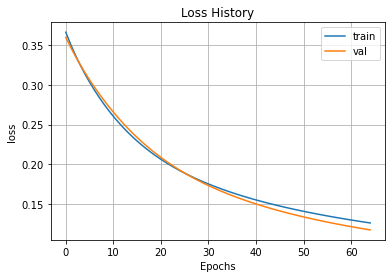

In [108]:
fig, ax = plt.subplots() 
ax.plot(range(len(loss_tr)),loss_tr, label="train")
ax.plot(range(len(dev_loss)),dev_loss,label="val")
ax.set(xlabel="Epochs",ylabel="loss",title="Loss History")
ax.grid()
plt.legend(["train","val"], loc="upper right")           
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [109]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]
           
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
print('Accuracy:', accuracy_score(Y_te,preds_te))

Precision: 0.7683480460115697
Recall: 0.7688888888888888
F1-Score: 0.7677538217703616
Accuracy: 0.7688888888888888


<ipython-input-39-c4db2328e62e>:12: RuntimeWarning: invalid value encountered in true_divide
  h_vecs.append((np.sum(W[0][x,:],axis=0)*1/len(x)).reshape(1,n))


In [58]:
del W
gc.collect()

3009

### Discuss how did you choose model hyperparameters ? 

| Parameters | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| lr=0.001, dropout=0.2,tolerance=0.001,embedding=100  | 0.3782  | 0.3744   | 0.3702   | 0.3744   |
| lr=0.001, dropout=0.1,tolerance=0.001,embedding=500  | 0.7817   | 0.7811   | 0.7803    | 0.7811    |
| lr=0.01, dropout=0.1,tolerance=0.001,embedding=400   | 0.7582   | 0.7577    | 0.7572   | 0.7577   |
| lr=0.0001, dropout=0.1,tolerance=0.0001,embedding=400    | 0.6975   | 0.6955   | 0.6934   | 0.6955   |
| lr=0.001, dropout=0.2,tolerance=0.001,embedding=500    | 0.7920    | 0.7888    | 0.7882    | 0.7888   |



lr=0.001, dropout=0.2,tolerance=0.001,embedding=500 

The above combination of the parameters have been chosen because:
- They give higher F-1 score and the learning curve for both train and dev appear to be almost converging
- Keeping the learning rate low has been beneficial in getting a better model in a way that with 100 epochs the model has been steadily able to reduce the losses for both train and dev data.
- Increasing the embedding size and regularisation(droupout) has also resulted in higher accuracy and an overall better model

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [25]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = np.array(line.strip('\n').split()[1:]).astype(np.float32)
                    w_emb[word2id[word]] +=emb
    return w_emb

In [26]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_vocabid_dict)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [27]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[1], num_classes=3)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev, 
                            Y_dev,
                            lr=0.0001, 
                            dropout=0.1,
                            freeze_emb=False,
                            tolerance=0.0001,
                            epochs=100)

Training started:
Epoch: 0, Training Loss: 0.3605096
Epoch: 0, Validation Loss: 0.3487573
Epoch: 1, Training Loss: 0.2939935
Epoch: 1, Validation Loss: 0.2922266
Epoch: 2, Training Loss: 0.2512571
Epoch: 2, Validation Loss: 0.2533428
Epoch: 3, Training Loss: 0.2224564
Epoch: 3, Validation Loss: 0.2257874
Epoch: 4, Training Loss: 0.2022797
Epoch: 4, Validation Loss: 0.2052170
Epoch: 5, Training Loss: 0.1876742
Epoch: 5, Validation Loss: 0.1896839
Epoch: 6, Training Loss: 0.1766718
Epoch: 6, Validation Loss: 0.1770388
Epoch: 7, Training Loss: 0.1680934
Epoch: 7, Validation Loss: 0.1674262
Epoch: 8, Training Loss: 0.1613169
Epoch: 8, Validation Loss: 0.1588052
Epoch: 9, Training Loss: 0.1558293
Epoch: 9, Validation Loss: 0.1520326
Epoch: 10, Training Loss: 0.1512520
Epoch: 10, Validation Loss: 0.1462639
Epoch: 11, Training Loss: 0.1474611
Epoch: 11, Validation Loss: 0.1408007
Epoch: 12, Training Loss: 0.1442519
Epoch: 12, Validation Loss: 0.1364323
Epoch: 13, Training Loss: 0.1414384
Epoc

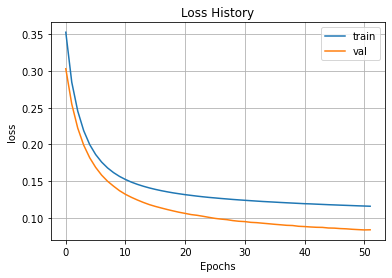

In [84]:
fig, ax = plt.subplots() 
ax.plot(range(len(loss_tr)),loss_tr, label="train")
ax.plot(range(len(dev_loss)),dev_loss,label="val")
ax.set(xlabel="Epochs",ylabel="loss",title="Loss History")
ax.grid()
plt.legend(["train","val"], loc="upper right")           
plt.show()

In [28]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]
           
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
print('Accuracy:', accuracy_score(Y_te,preds_te))

<ipython-input-21-2f240730fc6d>:12: RuntimeWarning: invalid value encountered in true_divide
  h_vecs.append((np.sum(W[0][x,:],axis=0)*1/len(x)).reshape(1,n))


Precision: 0.8785365963867188
Recall: 0.8766666666666666
F1-Score: 0.8764464898452068
Accuracy: 0.8766666666666667


### Discuss how did you choose model hyperparameters ? 

| Parameters | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| lr=0.001, dropout=0.2,tolerance=0.0001  | 0.8756   | 0.8733   | 0.8730   | 0.8733    |
| lr=0.001, dropout=0.1,tolerance=0.0001  | 0.8724  | 0.87    | 0.8700    | 0.87    |
| lr=0.0001, dropout=0.1,tolerance=0.0001    | 0.8745    | 0.8722    | 0.8821   | 0.8722    |
| lr=0.01, dropout=0.1,tolerance=0.0001    | 0.8707   | 0.8688    | 0.8684    | 0.8688  |



lr=0.0001, dropout=0.1,tolerance=0.0001

The above combination of the parameters have been chosen because:

- They have returned better metrics and the learning curve for both train and dev appear to be almost converging
- Keeping the learning rate low again has been beneficial in getting a better model
- Also the model has run for more epochs than for any other combinations indicating better learning
- Low Regularisation(droupout) 0.1 yeiled higher accuracy as compared to other combinations

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [101]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[2], num_classes=3)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(X_tr, Y_tr,
                            W,
                            X_dev, 
                            Y_dev,
                            lr=0.0001, 
                            dropout=0.1,
                            freeze_emb=True,
                            tolerance=0.0001,
                            epochs=100)

Training started:
Epoch: 0, Training Loss: 0.3362570
Epoch: 0, Validation Loss: 0.2343529
Epoch: 1, Training Loss: 0.2045834
Epoch: 1, Validation Loss: 0.1699535
Epoch: 2, Training Loss: 0.1687308
Epoch: 2, Validation Loss: 0.1437720
Epoch: 3, Training Loss: 0.1531911
Epoch: 3, Validation Loss: 0.1295978
Epoch: 4, Training Loss: 0.1441007
Epoch: 4, Validation Loss: 0.1192124
Epoch: 5, Training Loss: 0.1380375
Epoch: 5, Validation Loss: 0.1149436
Epoch: 6, Training Loss: 0.1338094
Epoch: 6, Validation Loss: 0.1078777
Epoch: 7, Training Loss: 0.1305308
Epoch: 7, Validation Loss: 0.1034267
Epoch: 8, Training Loss: 0.1277654
Epoch: 8, Validation Loss: 0.1001700
Epoch: 9, Training Loss: 0.1255398
Epoch: 9, Validation Loss: 0.0968701
Epoch: 10, Training Loss: 0.1236953
Epoch: 10, Validation Loss: 0.0952696
Epoch: 11, Training Loss: 0.1219387
Epoch: 11, Validation Loss: 0.0919048
Epoch: 12, Training Loss: 0.1201831
Epoch: 12, Validation Loss: 0.0912848
Epoch: 13, Training Loss: 0.1187880
Epoc

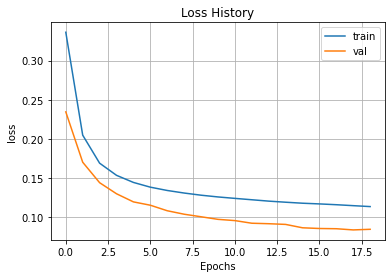

In [102]:
fig, ax = plt.subplots() 
ax.plot(range(len(loss_tr)),loss_tr, label="train")
ax.plot(range(len(dev_loss)),dev_loss,label="val")
ax.set(xlabel="Epochs",ylabel="loss",title="Loss History")
ax.grid()
plt.legend(["train","val"], loc="upper right")           
plt.show()

In [103]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y'])
            for x,y in zip(X_te,Y_te)]
           
print('Precision:', precision_score(Y_te,preds_te,average='macro'))
print('Recall:', recall_score(Y_te,preds_te,average='macro'))
print('F1-Score:', f1_score(Y_te,preds_te,average='macro'))
print('Accuracy:', accuracy_score(Y_te,preds_te))

<ipython-input-39-c4db2328e62e>:12: RuntimeWarning: invalid value encountered in true_divide
  h_vecs.append((np.sum(W[0][x,:],axis=0)*1/len(x)).reshape(1,n))


Precision: 0.8680451589152044
Recall: 0.8655555555555555
F1-Score: 0.8662289128820846
Accuracy: 0.8655555555555555


### Discuss how did you choose model hyperparameters ? 

| Parameters | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| lr=0.00001, dropout=0.1,tolerance=0.0001  | 0.8512    | 0.85    | 0.8501    | 0.85    |
| lr=0.0001, dropout=0.1,tolerance=0.0001  | 0.8680   | 0.8655     | 0.8662     | 0.8655     |
| lr=0.001, dropout=0.1,tolerance=0.0001    | 0.8684    | 0.8677     | 0.8668     | 0.8677    |
| lr=0.01, dropout=0.1,tolerance=0.0001    | 0.8460   | 0.84    | 0.8382    | 0.84    |



lr=0.0001, dropout=0.1,tolerance=0.0001
The above combination of the parameters have been chosen because:

- They have returned a good F-1 score and the learning curve for both train and dev are better than for other combinations
- Keeping the learning rate lower again has been beneficial in getting a better model but an even lower learning rate doesnt return good metrics



## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.7920  | 0.7888   | 0.7882   | 0.7888   |
| Average Embedding (Pre-trained)  | 0.8745    | 0.8722    | 0.8821   | 0.8722    
| Average Embedding (Pre-trained) + X hidden layers    | 0.8680   | 0.8655     | 0.8662     | 0.8655     |


Please discuss why your best performing model is better than the rest.

Average Embedding (Pre-trained) model is better than the other two as primarily because of the better performance which is evident from the metrics. 
One reason that this model performs better is the use of pretrained vectors as compared to the random embedding weights used for the Average Emdedding model for which the weights were randomly assigned.
As for the Average Embedding (Pre-trained) + X hidden layers model, adding another hidden layer may have added uncessary complexity in the architecture which did not contribute as aexpected but it still performs better than the Average Embedding model.